In [83]:
#!pip install torch

In [84]:
#pip install --upgrade torch torchvision
#!pip install scikit-image

In [1]:
#pip install librosa
import torch                                         # imports the core PyTorch library
import torch.nn as nn                                # torch.nn library is a high-level interface for building and training neural networks
import torch.optim as optim                          # Needed for optimizer
from torch.utils.data import DataLoader              # Needed for loading data
from torchvision import datasets, transforms         # Needed for making sure data is properly formatted 
import torch.nn.functional as F                      # Needed for functional equation in forward loop
import numpy as np                                   # Needed for outputting weights and biases
from torchvision.datasets import VisionDataset       # VisionDataset is is designed to be a base class for datasets in computer vision tasks
from PIL import Image                                # Needed for manipulating png image files 
import os                                            # Needed for operating system for dealing with dir of training and test png files
from torchvision import transforms
from skimage import exposure
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
#import librosa
#import librosa.display
import matplotlib.pyplot as plt
#from python_speech_features import mfcc
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
#import pygame
import random
#from skimage import exposure


# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")

Is MPS (Metal Performance Shader) built? True


In [2]:
class DogEmotions(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(DogEmotions, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split
        self.data_folder = "training" if split == 'train' else "testing"
        self.images_folder = os.path.join(self.root, self.data_folder)

        self.image_paths = self._get_image_paths()
        self.mean = np.array([0.46175721, 0.42624477, 0.3737414 ])
        self.std = np.array([0.24006152, 0.2344247,  0.22821001])

        #Calculated mean: [0.46175721, 0.42624477, 0.3737414 ]
        #Calculated std: [0.24006152, 0.2344247,  0.22821001]

         # Add a check to ensure transform is not None
        if transform is None:
            self.transform = transforms.Compose([
                #transforms.CenterCrop((244, 244)),
                transforms.Resize((244, 244)),
                transforms.ToTensor(),
                #transforms.Resize((488, 488)),
                 #transforms.Lambda(lambda x: F.equalize_hist(x)),  # Adding histogram equalization
                #transforms.Lambda(lambda x: Image.fromarray(self.equalize_hist(np.array(x)))),
                #Commented out normalization for now
                #transforms.Normalize(mean=self.mean, std=self.std),
            ])
        else:
            self.transform = transform

    def equalize_hist(self, img):
        img_eq = exposure.equalize_hist(img)
        return img_eq

    def _get_image_paths(self):
        image_paths = []
        #print("Getting image paths...")
        #print(f"Checking folder: {self.images_folder}")

        for digit_folder in os.listdir(self.images_folder):
            digit_folder_path = os.path.join(self.images_folder, digit_folder)

            # Check if it's a directory before listing its contents
            if os.path.isdir(digit_folder_path):
                for image_name in os.listdir(digit_folder_path):
                    image_path = os.path.join(digit_folder_path, image_name)

                    # Skip files with the '.DS_Store' extension
                    if not image_path.endswith('.DS_Store'):
                        image_paths.append((image_path, int(digit_folder)))

        return image_paths

    def _split_dataset(self, dataset, train_size=0.70, val_size=0.15, test_size=0.15, random_state=None):
        # Extract images and labels from the dataset
        images, labels = zip(*dataset)

        # First, split into train and temp sets
        train_images, temp_images, train_labels, temp_labels = train_test_split(
            images, labels, test_size=(val_size + test_size), random_state=random_state
        )

        # Second, split temp set into validation and test sets
        val_images, test_images, val_labels, test_labels = train_test_split(
            temp_images, temp_labels, test_size=test_size / (val_size + test_size), random_state=random_state
        )

        train_dataset = list(zip(train_images, train_labels))
        val_dataset = list(zip(val_images, val_labels))
        test_dataset = list(zip(test_images, test_labels))

        return train_dataset, val_dataset, test_dataset

    def get_datasets(self):
        if self.split not in ['train', 'val', 'test']:
            raise ValueError("Invalid split. Use 'train', 'val', or 'test'.")

        dataset = self._get_image_paths()
        train_dataset, val_dataset, test_dataset = self._split_dataset(dataset)

        return train_dataset, val_dataset, test_dataset
    def __getitem__(self, index):
        if index < 0 or index >= len(self.image_paths):
            raise IndexError("Index out of range")

        image_path, label = self.image_paths[index]

    # Skip files with the '.DS_Store' extension
        while image_path.endswith('.DS_Store'):
            index += 1
            if index >= len(self.image_paths):
                raise IndexError("Index out of range")
            image_path, label = self.image_paths[index]

    # Open and read the image
        print(f"Opening image: {image_path}")

        with Image.open(image_path) as image:
        # Convert image to RGB, regardless of its mode
            image = image.convert('RGB')
            print(f"Image shape before transformation: {np.array(image).shape}", flush=True)

        # Ensure the image has 3 channels
            if image.mode != 'RGB':
                image = image.convert('RGB')

            if self.transform is not None:
                image = self.transform(image)
            print(f"Image shape after transformation: {image.shape}", flush=True)

        return image, label

    def __len__(self):
        return len(self.image_paths)

    def custom_collate(self, batch):
    # Unpack the batch
        image_paths, labels = zip(*batch)

    # Load images and apply transformations
        image_tensors = [self.transform(Image.open(img_path).convert('RGB')) for img_path in image_paths]

    # Convert labels to PyTorch tensor
        label_tensor = torch.tensor(labels, dtype=torch.long)

        return torch.stack(image_tensors), label_tensor


In [3]:
import numpy as np
from PIL import Image
import os

# Assuming you have a folder containing images
folder_path = '/Users/peternoble/Downloads/DogEmotions2/training/0'
#folder_path = '/Users/peternoble/Desktop/Dog_Emotions/training/2'

# Get all image paths in the folder
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith(('.png', '.jpg', '.jpeg'))]

# Calculate mean and std
mean = np.zeros(3)
std = np.zeros(3)

for img_path in image_paths:
    img = np.array(Image.open(img_path).convert('RGB')) / 255.0
    mean += np.mean(img, axis=(0, 1))
    std += np.std(img, axis=(0, 1))

mean /= len(image_paths)
std /= len(image_paths)

print("Calculated mean:", mean)
print("Calculated std:", std)

Calculated mean: [0.45628292 0.42031068 0.3604396 ]
Calculated std: [0.2422242  0.23606527 0.2257146 ]


In [4]:
# Function to print class distribution
def print_class_distribution(loader, name):
    labels = [label for _, label in loader.dataset]
    print(f"{name} set size: {len(loader.dataset)}")
    for class_label in range(3):  # Assuming you have 4 classes
        count = labels.count(class_label)
        print(f"Class {class_label}: {count} examples in the {name} set")

# Create separate instances for training, validation, and test datasets
root_directory = '/Users/peternoble/Downloads/DogEmotions2'
#root_directory = '/Users/peternoble/Desktop/Dog_Emotions'
DogEmotions_instance = DogEmotions(root_directory, split='train')
train_dataset, val_dataset, test_dataset = DogEmotions_instance.get_datasets()

# Create data loaders
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=DogEmotions_instance.custom_collate)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=DogEmotions_instance.custom_collate)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=DogEmotions_instance.custom_collate)

# Print dataset sizes
print_class_distribution(train_loader, "Train")
print_class_distribution(val_loader, "Validation")
print_class_distribution(test_loader, "Test")


Train set size: 2017
Class 0: 342 examples in the Train set
Class 1: 1074 examples in the Train set
Class 2: 601 examples in the Train set
Validation set size: 432
Class 0: 76 examples in the Validation set
Class 1: 226 examples in the Validation set
Class 2: 130 examples in the Validation set
Test set size: 433
Class 0: 73 examples in the Test set
Class 1: 225 examples in the Test set
Class 2: 135 examples in the Test set


In [5]:
# Set the path where you want to save the images. Useful for visualizing the actual images used for validation
output_path = '/Users/peternoble/Desktop/results'
# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)
# Variables to store all images and labels
all_images = []
all_labels = []

# Iterate through the validation loader and concatenate images and labels
for batch_idx, (images, labels) in enumerate(val_loader):
    # Check for NaN or infinity values
    if torch.isnan(images).any() or torch.isinf(images).any():
        print(f"Found invalid values in batch {batch_idx}. Skipping...")
        continue
    
    # Clamp image values to [0, 1]
    images = torch.clamp(images, 0, 1)

    all_images.append(images)
    all_labels.append(labels)

# Concatenate the lists to get all images and labels
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Define a function to save images
def save_images(images, labels, output_path):
    for i in range(len(images)):
        image, label = images[i], labels[i]
        # Assuming the images are in the range [0, 1], and using torchvision to convert to PIL
        image_pil = transforms.ToPILImage()(image)
        image_pil.save(os.path.join(output_path, f"image_{i}_label_{label}.png"))

# Save all equalized images from the validation dataset
save_images(all_images, all_labels, output_path)


In [6]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=2)

        # Layer 3
        self.conv3 = nn.Conv2d(32, 16, kernel_size=2, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 4
        self.conv4 = nn.Conv2d(16, 8, kernel_size=2, padding=1)
        self.bn4 = nn.BatchNorm2d(8)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 5
        self.conv5 = nn.Conv2d(8, 4, kernel_size=2, padding=1)
        self.bn5 = nn.BatchNorm2d(4)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 6
        self.conv6 = nn.Conv2d(4, 4, kernel_size=2, padding=1)
        self.bn6 = nn.BatchNorm2d(4)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 7
        self.conv7 = nn.Conv2d(4, 16, kernel_size=2, padding=1)
        self.bn7 = nn.BatchNorm2d(16)
        self.relu7 = nn.ReLU()
        self.pool7 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 8
        self.conv8 = nn.Conv2d(16, 32, kernel_size=2, padding=1)
        self.bn8 = nn.BatchNorm2d(32)
        self.relu8 = nn.ReLU()
        self.pool8 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adjusted fully connected layer
        #self.fc = nn.Linear(1952, num_classes)  # Adjust the size based on your model architecture
        #self.fc = nn.Linear(128, num_classes)  # Adjust the size based on your model architecture
        self.fc = nn.Linear(32, num_classes)  # Adjust the size based on your model architecture

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.pool5(self.relu5(self.bn5(self.conv5(x))))
        x = self.pool6(self.relu6(self.bn6(self.conv6(x))))
        x = self.pool7(self.relu7(self.bn7(self.conv7(x))))
        x = self.pool8(self.relu8(self.bn8(self.conv8(x))))

        # Flatten the output before passing it through the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully connected layer
        x = self.fc(x)

        return x

# Create an instance of the CustomCNN model
model = CustomCNN()

# Print the model architecture
print(model)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(

In [7]:
# Assuming sugarcane_loader is your DataLoader
for inputs, labels in val_loader:
    print("Input shape:", inputs.shape)
    break

Input shape: torch.Size([32, 3, 244, 244])


EarlyStopping counter: 0 out of 15
Epoch 1/50, Training Loss: 1.0206, Training Accuracy: 0.5141, Validation Loss: 0.9850, Validation Accuracy: 0.5208
EarlyStopping counter: 0 out of 15
Epoch 2/50, Training Loss: 0.9675, Training Accuracy: 0.5320, Validation Loss: 0.9623, Validation Accuracy: 0.5162
EarlyStopping counter: 0 out of 15
Epoch 3/50, Training Loss: 0.9165, Training Accuracy: 0.5462, Validation Loss: 0.9446, Validation Accuracy: 0.5370
EarlyStopping counter: 0 out of 15
Epoch 4/50, Training Loss: 0.9008, Training Accuracy: 0.5569, Validation Loss: 0.8952, Validation Accuracy: 0.5671
EarlyStopping counter: 0 out of 15
Epoch 5/50, Training Loss: 0.8484, Training Accuracy: 0.5683, Validation Loss: 0.8687, Validation Accuracy: 0.5764
EarlyStopping counter: 0 out of 15
Epoch 6/50, Training Loss: 0.8253, Training Accuracy: 0.5774, Validation Loss: 0.8579, Validation Accuracy: 0.5856
EarlyStopping counter: 1 out of 15
Epoch 7/50, Training Loss: 0.7956, Training Accuracy: 0.5874, Val

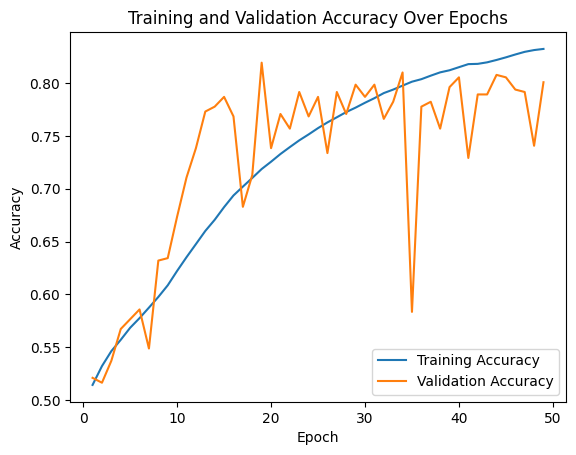

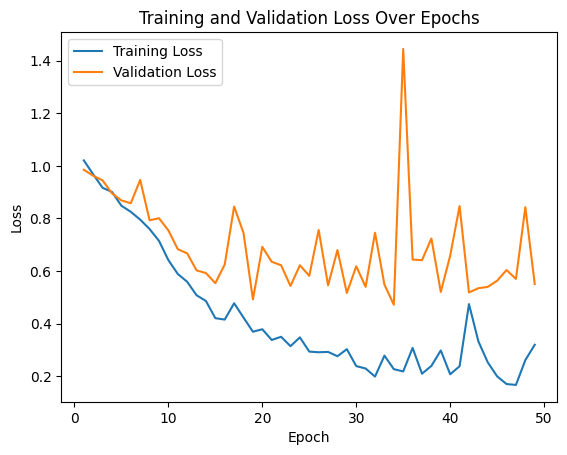

In [8]:
#Instantiate your model, optimizer, and criterion
model = CustomCNN()  # Create an instance of your CustomModel
#optimizer = optim.Adam(model.parameters(), lr=0.001)
# Assuming you have a validation DataLoader named val_loader
# Specify the weight decay (regularization strength)
weight_decay = 0.01
#loaded_model = CustomCNN()
#loaded_model.load_state_dict(torch.load('complex_model_95_8.pth'))

# Define your optimizer and pass the weight_decay parameter L2 regular
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define RMSprop optimizer
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

criterion = nn.CrossEntropyLoss()

num_epochs = 50

class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

        if self.verbose:
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')

        return self.early_stop

# Create an instance of EarlyStopping before the training loop
early_stopping = EarlyStopping(patience=15, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize variables for accuracy calculation
correct_train = 0
total_train = 0
correct_val = 0
total_val = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()

    average_train_loss = running_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    running_val_loss = 0.0

    # Reset variables for accuracy calculation
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()

            _, predicted_val = val_outputs.max(1)
            total_val += val_labels.size(0)
            correct_val += predicted_val.eq(val_labels).sum().item()

    average_val_loss = running_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Call early_stopping within the loop
    if early_stopping(average_val_loss, model):
        print("Early stopping")
        break

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting the accuracy curve
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plotting the loss curve
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [9]:
# Save the model state_dict
torch.save(model.state_dict(), 'dog_emotions_model.pth')


Test Accuracy: 79.7%
Angry: Correctly classified 53/73 (72.6%)
Relaxed_Sad: Correctly classified 180/225 (80.0%)
Happy: Correctly classified 112/135 (83.0%)


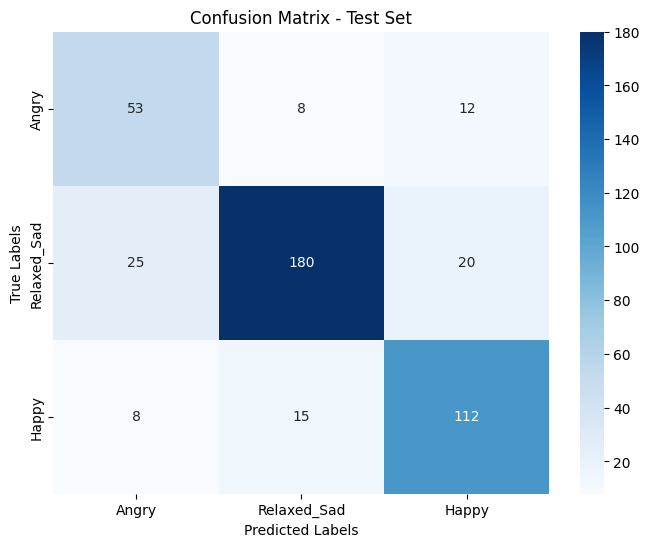

Classification Report - Test Set:
               precision    recall  f1-score   support

       Angry       0.62      0.73      0.67        73
 Relaxed_Sad       0.89      0.80      0.84       225
       Happy       0.78      0.83      0.80       135

    accuracy                           0.80       433
   macro avg       0.76      0.79      0.77       433
weighted avg       0.81      0.80      0.80       433

Validation Accuracy: 80.1%
Angry: Correctly classified 59/76 (77.6%)
Relaxed_Sad: Correctly classified 189/226 (83.6%)
Happy: Correctly classified 98/130 (75.4%)


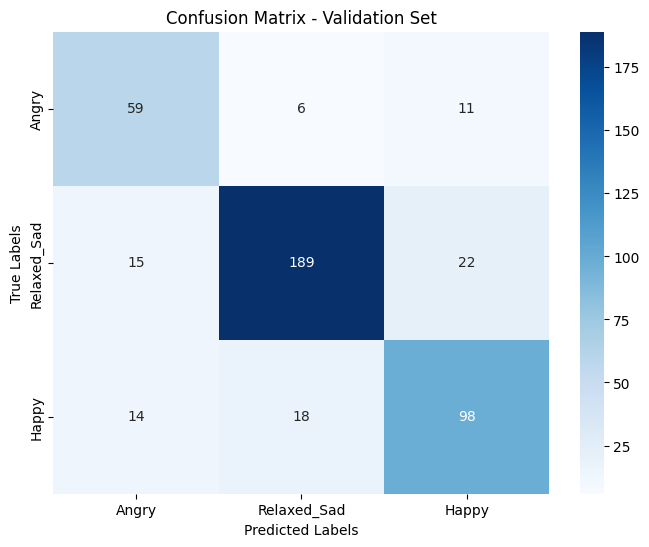

Classification Report - Validation Set:
               precision    recall  f1-score   support

       Angry       0.67      0.78      0.72        76
 Relaxed_Sad       0.89      0.84      0.86       226
       Happy       0.75      0.75      0.75       130

    accuracy                           0.80       432
   macro avg       0.77      0.79      0.78       432
weighted avg       0.81      0.80      0.80       432



In [10]:
# Assuming you have a validation DataLoader named val_loader
loaded_model = CustomCNN()
loaded_model.load_state_dict(torch.load('dog_emotions_model.pth'))

def evaluate_model(loader, custom_labels, dataset_name):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            try:
                inputs = inputs.view(inputs.size(0), 3, 244, 244)  # Ensure the input size is correct
                outputs = model(inputs)
                predictions = torch.argmax(outputs, dim=1)
                all_predictions.extend(predictions.tolist())
                all_labels.extend(labels.tolist())  # Populate the true labels
            except Exception as e:
                print(f"An error occurred: {e}")

    # Compute accuracy for the dataset
    if len(all_labels) > 0:
        accuracy = sum(p == l for p, l in zip(all_predictions, all_labels)) / len(all_labels)
        print(f"{dataset_name} Accuracy: {accuracy:.1%}")
    else:
        print(f"No labels available for computing {dataset_name} accuracy.")

    # Analyze classification breakdown for the dataset
    for class_label, custom_label in enumerate(custom_labels):
        correct = sum(p == class_label and l == class_label for p, l in zip(all_predictions, all_labels))
        total_in_set = all_labels.count(class_label)

        if total_in_set == 0:
            print(f"{custom_label}: No examples in the {dataset_name} set")
        else:
            percentage = correct / total_in_set if total_in_set != 0 else 0.0
            print(f"{custom_label}: Correctly classified {correct}/{total_in_set} ({percentage:.1%})")

    # Return the lists of all_labels and all_predictions
    return all_labels, all_predictions

# Define custom labels
custom_labels = ['Angry', 'Relaxed_Sad', 'Happy']

# Evaluate on the test set
all_labels_test, all_predictions_test = evaluate_model(test_loader, custom_labels, "\nTest")

# Compute confusion matrix for the test set
conf_matrix_test = confusion_matrix(all_labels_test, all_predictions_test)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=custom_labels, yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Generate and print classification report for the test set
class_report_test = classification_report(all_labels_test, all_predictions_test, target_names=custom_labels)
print("Classification Report - Test Set:\n", class_report_test)

# Evaluate on the validation set
all_labels_val, all_predictions_val = evaluate_model(val_loader, custom_labels, "Validation")

# Compute confusion matrix for the validation set
conf_matrix_val = confusion_matrix(all_labels_val, all_predictions_val)

# Plot the confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=custom_labels, yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Generate and print classification report for the validation set
class_report_val = classification_report(all_labels_val, all_predictions_val, target_names=custom_labels)
print("Classification Report - Validation Set:\n", class_report_val)

In [11]:
import torch

# Load the model checkpoint
checkpoint = torch.load("/Users/peternoble/Desktop/dog_emotions_model.pth", map_location=torch.device('cpu'))

# Inspect the contents of the checkpoint
print(checkpoint.keys())


odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'conv4.weight', 'conv4.bias', 'bn4.weight', 'bn4.bias', 'bn4.running_mean', 'bn4.running_var', 'bn4.num_batches_tracked', 'conv5.weight', 'conv5.bias', 'bn5.weight', 'bn5.bias', 'bn5.running_mean', 'bn5.running_var', 'bn5.num_batches_tracked', 'conv6.weight', 'conv6.bias', 'bn6.weight', 'bn6.bias', 'bn6.running_mean', 'bn6.running_var', 'bn6.num_batches_tracked', 'conv7.weight', 'conv7.bias', 'bn7.weight', 'bn7.bias', 'bn7.running_mean', 'bn7.running_var', 'bn7.num_batches_tracked', 'conv8.weight', 'conv8.bias', 'bn8.weight', 'bn8.bias', 'bn8.running_mean', 'bn8.running_var', 'bn8.num_batches_tracked', 'fc.weight',

In [12]:
import torch

# Load the model checkpoint
checkpoint_path = "/Users/peternoble/Desktop/dog_emotions_model.pth"
model = CustomCNN()
model.load_state_dict(torch.load(checkpoint_path))
model.eval()
# Access the parameters of the BatchNorm2d layer
bn_key = 'bn8.'
bn_params = {key[len(bn_key):]: value for key, value in model.state_dict().items() if bn_key in key}

# Access scale (weight) and shift (bias) parameters
gamma = bn_params['weight']
beta = bn_params['bias']

# Access running mean and running variance parameters
running_mean = bn_params['running_mean']
running_var = bn_params['running_var']

# Access num_batches_tracked parameter
num_batches_tracked = bn_params['num_batches_tracked']

# Print or use the parameters as needed
print("Weight (Gamma):", gamma)
print("Bias (Beta):", beta)
print("Running Mean:", running_mean)
print("Running Variance:", running_var)
print("Num Batches Tracked:", num_batches_tracked)

# Open a text file in write mode
with open("batch_norm_parameters.txt", "w") as file:
    # Write the parameters to the file
    file.write(f"Weight (Gamma): {gamma}\n")
    file.write(f"Bias (Beta): {beta}\n")
    file.write(f"Running Mean: {running_mean}\n")
    file.write(f"Running Variance: {running_var}\n")
    file.write(f"Num Batches Tracked: {num_batches_tracked}\n")

# Print a message indicating the file has been saved
print("Batch normalization parameters saved to batch_norm_parameters.txt")


Weight (Gamma): tensor([0.2421, 0.6517, 0.7137, 0.0070, 0.5303, 0.4873, 0.5686, 0.6924, 0.4553,
        0.2300, 0.4664, 0.4022, 0.6846, 0.4057, 0.4098, 0.4579, 0.5266, 0.3157,
        0.6251, 0.6455, 0.6788, 0.1144, 0.4966, 0.2436, 0.1986, 0.6828, 0.6356,
        0.7407, 0.4212, 0.0177, 0.2577, 0.6711])
Bias (Beta): tensor([ 0.0348, -0.0064,  0.1010,  0.0049,  0.0627,  0.0596, -0.0276, -0.0086,
         0.0428,  0.0331,  0.0551,  0.0368,  0.0053, -0.0107,  0.0417,  0.0454,
        -0.0292,  0.0129,  0.0153,  0.0727,  0.1081,  0.0189,  0.0004,  0.0586,
         0.0368, -0.0470, -0.0058,  0.1157, -0.0035,  0.0041,  0.0381, -0.0142])
Running Mean: tensor([-0.0302, -0.0463,  0.0630, -0.0057, -0.0142, -0.0358,  0.0263,  0.0369,
        -0.0872,  0.0343,  0.1079,  0.1314,  0.0927,  0.0914,  0.0720,  0.0742,
         0.0306,  0.0671,  0.0330,  0.1344,  0.0251,  0.0659,  0.0907,  0.0799,
        -0.0031,  0.0405,  0.0918,  0.0798,  0.0465, -0.0216,  0.0548,  0.0631])
Running Variance: tensor([

In [44]:
model.eval()  # Set the model to evaluation mode
params = list(loaded_model.parameters())
#print(params[0].shape)
#print(params[1].shape)
#print(params[2].shape)
#print(params[3].shape)
print(params)


[Parameter containing:
tensor([[[[-1.2862e-01, -7.4132e-02],
          [-5.1123e-02, -2.4877e-03]],

         [[-1.9497e-01,  4.1154e-02],
          [-1.8533e-01, -3.4249e-02]],

         [[ 1.6030e-01,  2.4662e-01],
          [-8.4199e-02, -2.5276e-01]]],


        [[[-6.9489e-03, -1.1550e-01],
          [ 1.4490e-01,  1.5836e-01]],

         [[ 1.6745e-01, -6.6469e-02],
          [ 9.3122e-02, -6.3083e-02]],

         [[ 2.7279e-01, -5.6057e-02],
          [-2.7427e-01,  2.2126e-01]]],


        [[[-2.0808e-01,  2.3376e-01],
          [ 1.7773e-01,  1.2671e-01]],

         [[-5.4855e-02, -1.8969e-01],
          [-2.1482e-01,  1.1987e-01]],

         [[-2.3454e-01, -1.4718e-01],
          [ 1.3466e-01,  2.5079e-01]]],


        [[[ 1.0878e-01, -2.1913e-01],
          [-2.0339e-01,  3.4536e-03]],

         [[ 1.4468e-01, -2.6049e-01],
          [-1.4162e-01, -2.0044e-01]],

         [[-6.1424e-02, -1.1785e-01],
          [ 1.1778e-01, -5.3533e-02]]],


        [[[ 4.3818e-02,  1.9947e-

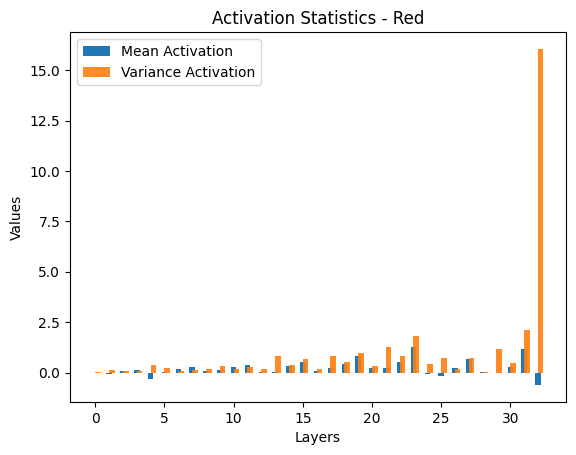

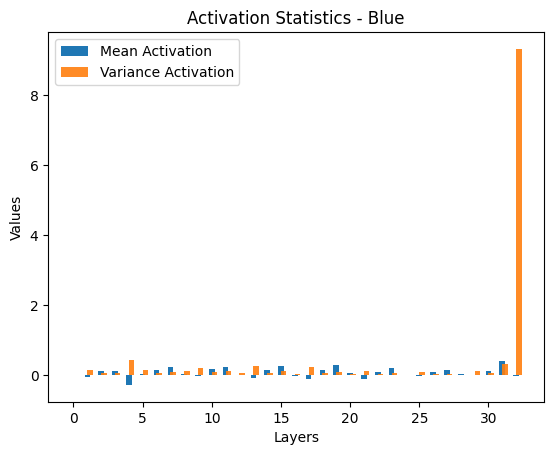

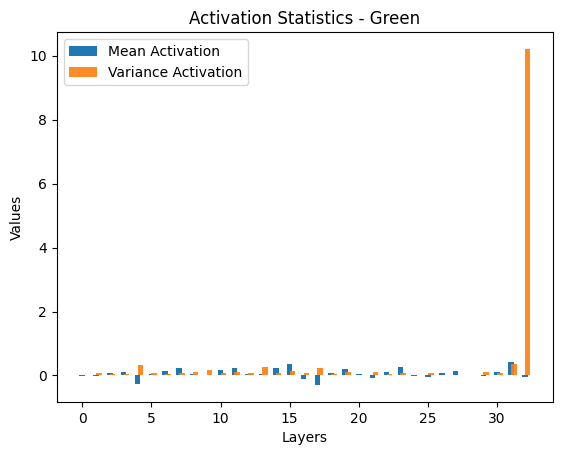

In [10]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import random
from torchvision import transforms
from PIL import Image

# Assuming you have already defined the CustomCNN class and loaded the model
# Also, define the 'model' and 'transform' variables before this code snippet

# Create a PdfPages object to store the plots
pdf_pages = PdfPages('activation_plots.pdf')

# List of directories to investigate
directory_paths = [
    '/Users/peternoble/Downloads/DogEmotions/training/0',
    '/Users/peternoble/Downloads/DogEmotions/training/1',
    '/Users/peternoble/Downloads/DogEmotions/training/2',
    #'/Users/peternoble/Downloads/DogEmotions/training/3',
 ]
#folder_path = '/Users/peternoble/Downloads/DogEmotions/training/0'

# Custom labels for each directory
#custom_labels = ['Angry', 'Sad', 'Relaxed', 'Happy']
custom_labels = ['Red', 'Blue', 'Green']

# Loop through each directory
for i, directory_path in enumerate(directory_paths):
    # Choose a random image file from the list
    random_image_file = random.choice(os.listdir(directory_path))

    # Construct the full path to the randomly chosen image file
    random_image_path = os.path.join(directory_path, random_image_file)

    # Open the image using PIL
    random_image = Image.open(random_image_path)

    # Define the transformation for the image
    transform = transforms.Compose([
        #transforms.Resize((488, 488)),
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
    ])

    # Apply the transformation to the image
    input_image = transform(random_image).unsqueeze(0)  # Add batch dimension

    # Create a new figure for each plot
    fig, ax = plt.subplots()

    # Create a list to store the activation statistics
    activation_stats = []

    # Define a hook to store the activation statistics at each layer
    def hook_fn(module, input, output):
        mean_activation = output.mean().item()
        var_activation = output.var().item()
        activation_stats.append((mean_activation, var_activation))

    # Register the hook to each layer in your model
    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass to obtain activation statistics
    with torch.no_grad():
        model(input_image)

    # Remove the hooks
    for hook in hooks:
        hook.remove()

    # Visualize activation statistics
    layer_names = [f'Layer {i+1}' for i in range(len(activation_stats))]
    mean_activations, var_activations = zip(*activation_stats)

    # Create separate x-values for mean and variance
    x_mean = [i for i in range(len(mean_activations))]
    x_var = [i + 0.2 for i in range(len(var_activations))]  # Add a small offset for variance

    # Plot the activation statistics
    ax.bar(x_mean, mean_activations, width=0.4, label='Mean Activation')
    ax.bar(x_var, var_activations, width=0.4, label='Variance Activation', alpha=0.9)
    ax.set_xlabel('Layers')
    ax.set_ylabel('Values')
    ax.set_title(f'Activation Statistics - {custom_labels[i]}')
    ax.legend()

    # Save the current plot to the PDF
    pdf_pages.savefig(fig)

    # Show the current plot on the screen
    plt.show()

    # Close the current plot
    plt.close()

# Close the PdfPages object
pdf_pages.close()


In [40]:
# Assuming you have a validation DataLoader named val_loader
loaded_model = CustomCNN()

loaded_model.load_state_dict(torch.load('/Users/peternoble/Desktop/dog_emotions_model.pth'))

# Set the model to evaluation mode
loaded_model.eval()

# Print and save the weights and biases
for name, param in loaded_model.named_parameters():
    if 'weight' in name or 'bias' in name:
        print(f"Parameter: {name}, Shape: {param.shape}")
        print("Values:")
        print(param.data)
        print("\n")

        # Flatten and save the parameters to text files
        flattened_params = param.data.flatten()
        np.savetxt(f'{name}.txt', flattened_params)


Parameter: conv1.weight, Shape: torch.Size([32, 3, 2, 2])
Values:
tensor([[[[-1.2862e-01, -7.4132e-02],
          [-5.1123e-02, -2.4877e-03]],

         [[-1.9497e-01,  4.1154e-02],
          [-1.8533e-01, -3.4249e-02]],

         [[ 1.6030e-01,  2.4662e-01],
          [-8.4199e-02, -2.5276e-01]]],


        [[[-6.9489e-03, -1.1550e-01],
          [ 1.4490e-01,  1.5836e-01]],

         [[ 1.6745e-01, -6.6469e-02],
          [ 9.3122e-02, -6.3083e-02]],

         [[ 2.7279e-01, -5.6057e-02],
          [-2.7427e-01,  2.2126e-01]]],


        [[[-2.0808e-01,  2.3376e-01],
          [ 1.7773e-01,  1.2671e-01]],

         [[-5.4855e-02, -1.8969e-01],
          [-2.1482e-01,  1.1987e-01]],

         [[-2.3454e-01, -1.4718e-01],
          [ 1.3466e-01,  2.5079e-01]]],


        [[[ 1.0878e-01, -2.1913e-01],
          [-2.0339e-01,  3.4536e-03]],

         [[ 1.4468e-01, -2.6049e-01],
          [-1.4162e-01, -2.0044e-01]],

         [[-6.1424e-02, -1.1785e-01],
          [ 1.1778e-01, -5.3533e

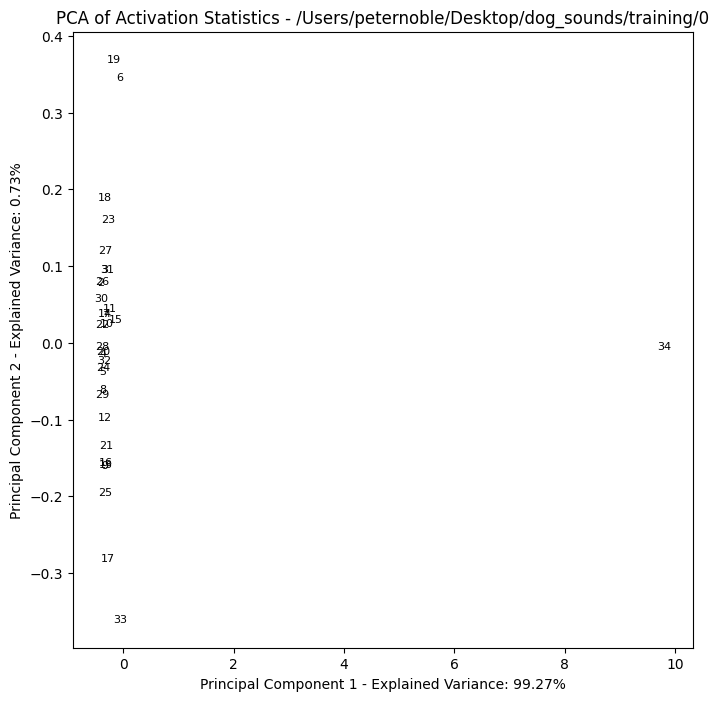

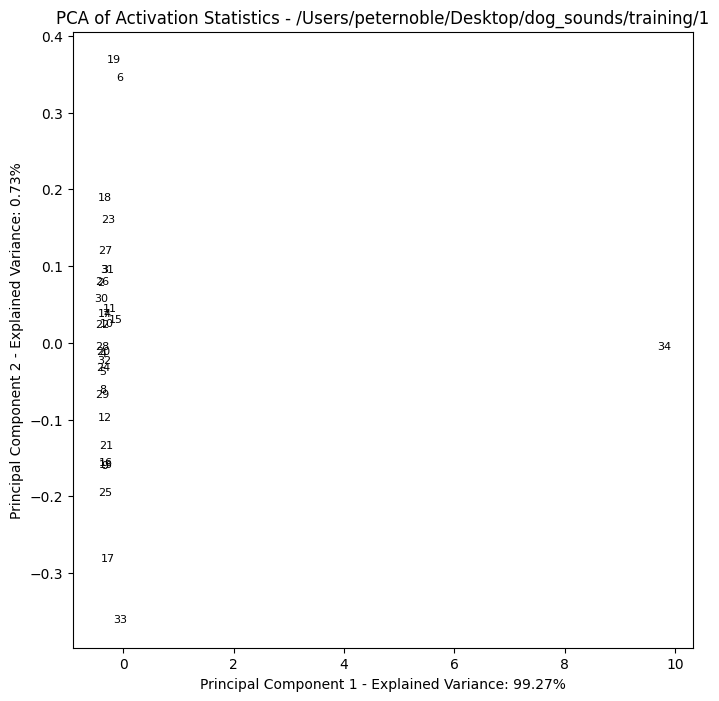

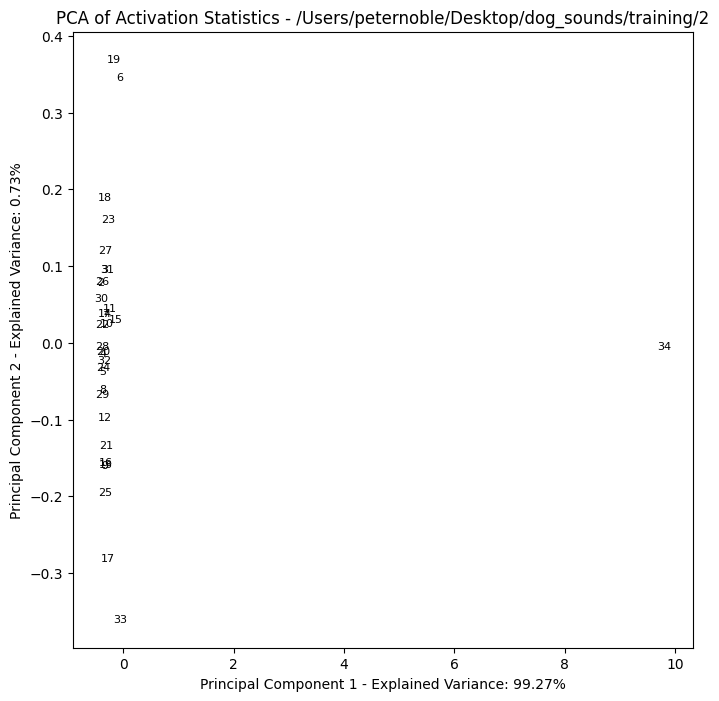

In [11]:
# CustomCNN class definition goes here
from sklearn.decomposition import PCA

# Function to visualize PCA results with labels and explained variance
def visualize_pca(mean_activations, var_activations, layer_numbers, directory_path):
    # Combine mean and variance into a single matrix
    activations_matrix = list(zip(mean_activations, var_activations))

    # Apply PCA
    pca = PCA(n_components=2)
    activations_pca = pca.fit_transform(activations_matrix)

    # Get the contribution of explained variances
    contribution_pc1 = pca.explained_variance_ratio_[0] * 100
    contribution_pc2 = pca.explained_variance_ratio_[1] * 100

    # Visualize PCA results with dots labeled by layer numbers
    plt.figure(figsize=(8, 8))

    # Annotate explained variance on axes
 #   plt.text(activations_pca[:, 0].max() + 0.1, 0, f'PC1 ({contribution_pc1:.2f}%)', fontsize=10, ha='left', va='center')
 #   plt.text(0, activations_pca[:, 1].max() + 0.1, f'PC2 ({contribution_pc2:.2f}%)', fontsize=10, ha='center', va='bottom')

    # Label dots with layer numbers
    for i, (x, y) in enumerate(activations_pca):
        plt.scatter(x, y, alpha=0)  # Make the dot invisible
        plt.text(x, y, str(layer_numbers[i]), fontsize=8, ha='center', va='center')

    plt.title(f'PCA of Activation Statistics - {directory_path}')
    plt.xlabel('Principal Component 1 - Explained Variance: {:.2f}%'.format(contribution_pc1))
    plt.ylabel('Principal Component 2 - Explained Variance: {:.2f}%'.format(contribution_pc2))
    plt.show()

# List of directory paths
directory_paths = [
    '/Users/peternoble/Desktop/dog_sounds/training/0',
    '/Users/peternoble/Desktop/dog_sounds/training/1',
    '/Users/peternoble/Desktop/dog_sounds/training/2',
    #'/Users/peternoble/Desktop/dog_sounds/training/3',
]

# Initialize lists to accumulate activation statistics for all datasets
all_mean_activations = []
all_var_activations = []

# Initialize layer numbers
layer_numbers = []

for directory_path in directory_paths:
    model = CustomCNN()

    # ... (rest of the code remains unchanged)

    # Accumulate activation statistics for the current dataset
    all_mean_activations.extend(mean_activations)
    all_var_activations.extend(var_activations)
    
    # Add layer numbers for the current dataset
    layer_numbers.extend([i + 2 for i in range(len(mean_activations))])

    # Visualize PCA of activation statistics for each dataset
    visualize_pca(mean_activations, var_activations, layer_numbers, directory_path)



In [12]:
# Create a list to store the feature maps
feature_maps = []

# Define a hook to store the feature maps at each layer
def hook_fn(module, input, output):
    feature_maps.append(output)

# Register the hook to each layer in your model
hooks = []
for layer in model.children():
    hook = layer.register_forward_hook(hook_fn)
    hooks.append(hook)

# Forward pass to obtain feature maps
with torch.no_grad():
    model(input_image)

# Remove the hooks
for hook in hooks:
    hook.remove()

# Print the shape of the feature maps
for i, feature_map in enumerate(feature_maps):
    print(f'Layer {i + 1} - Shape: {feature_map.shape}')

# Visualize the feature maps from the 2nd layer
layer_to_visualize = 1  # 0-based index, corresponds to the 2nd layer
feature_map_normalized = feature_maps[layer_to_visualize].squeeze().numpy()

# Visualize the feature map
#plt.figure(figsize=(8, 8))
#plt.imshow(feature_map_normalized, cmap='viridis')
#plt.title(f'Layer {layer_to_visualize + 1} - Feature Map')
#plt.axis('off')
#plt.show()

Layer 1 - Shape: torch.Size([1, 32, 245, 245])
Layer 2 - Shape: torch.Size([1, 32, 245, 245])
Layer 3 - Shape: torch.Size([1, 32, 245, 245])
Layer 4 - Shape: torch.Size([1, 32, 122, 122])
Layer 5 - Shape: torch.Size([1, 32, 121, 121])
Layer 6 - Shape: torch.Size([1, 32, 121, 121])
Layer 7 - Shape: torch.Size([1, 32, 121, 121])
Layer 8 - Shape: torch.Size([1, 32, 59, 59])
Layer 9 - Shape: torch.Size([1, 16, 60, 60])
Layer 10 - Shape: torch.Size([1, 16, 60, 60])
Layer 11 - Shape: torch.Size([1, 16, 60, 60])
Layer 12 - Shape: torch.Size([1, 16, 30, 30])
Layer 13 - Shape: torch.Size([1, 8, 31, 31])
Layer 14 - Shape: torch.Size([1, 8, 31, 31])
Layer 15 - Shape: torch.Size([1, 8, 31, 31])
Layer 16 - Shape: torch.Size([1, 8, 15, 15])
Layer 17 - Shape: torch.Size([1, 4, 16, 16])
Layer 18 - Shape: torch.Size([1, 4, 16, 16])
Layer 19 - Shape: torch.Size([1, 4, 16, 16])
Layer 20 - Shape: torch.Size([1, 4, 8, 8])
Layer 21 - Shape: torch.Size([1, 4, 9, 9])
Layer 22 - Shape: torch.Size([1, 4, 9, 9])

In [2]:
import torch

print(torch.__version__)

2.2.1
